In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

from IPython.display import Markdown as md

from sklearn.preprocessing import PolynomialFeatures

from shapely import geometry

import seaborn as sns
import statsmodels.api as sm

import warnings

sns.set(style='ticks', font_scale=1.3)
FIG_OPTIONS = {
    'figsize' : (3, 1),
    'dpi': 200
}

%matplotlib inline 

# Investigating latitudinal patterns in phytoplankton TPC parameters

Data from Thomas et al. 

In [2]:
plankton_o = pd.read_csv("../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')
plankton_o = gpd.GeoDataFrame(plankton_o, geometry = [geometry.Point(_['isolation.longitude'], _['isolation.latitude']) for i,_ in plankton_o.iterrows()])

**Filter** the data by fit quality. 

In [3]:
plankton = plankton_o[(plankton_o.minqual == "good") &
                    (plankton_o.maxqual == "good") &
                    (plankton_o.curvequal == "good")]

In [4]:
plankton = plankton[plankton.habitat == 'marine']

In [5]:
plankton.columns

Index(['isolate.code', 'source', 'isolation.latitude', 'isolation.longitude',
       'habitat', 'name', 'speciesname', 'former.name.1', 'former.name.2',
       'strain', 'clone', 'species', 'genus', 'family', 'order', 'class',
       'phylum', 'kingdom', 'domain', 'comment', 'group', 'mu.rsqrlist',
       'mu.wlist', 'mu.alist', 'mu.blist', 'mu.slist', 'mu.c.opt.list',
       'mu.c.opt.val.list', 'mu.g.opt.list', 'mu.g.opt.val.list', 'mu.n',
       'emp.max.growth', 'tmin', 'tmax', 'minqual', 'maxqual', 'curvequal',
       'abs.curveskew', 'rel.curveskew', 'used.for.optimum.analysis',
       'used.for.tmax.analysis', 'used.for.tmin.analysis',
       'used.for.niche.width.analysis', 'used.for.max.growth.rate.analysis',
       'geometry'],
      dtype='object')

Relevant parameter names/descriptions (from `../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/Dataset explanation.doc`)
```
23) mu.wlist = estimated thermal niche width (parameter ‘ɷ’ in the thermal reaction norm model)
24) mu.alist = estimate of parameter ‘a’ in the thermal reaction norm model
25) mu.blist = estimate of parameter ‘b’ in the thermal reaction norm model
26) mu.slist = variance parameter for the maximum likelihood model fit. 
27) mu.c.opt.list = estimate of parameter ‘z’ in the thermal reaction norm model
28) mu.g.opt.val.list = estimated specific growth rate (per day) when temperature is at ‘z’ (i.e. mu.c.opt.list)
29) mu.g.opt.list = estimated optimum temperature for growth 
30) mu.g.opt.val.list = estimated maximum specific growth rate (per day) based on the thermal reaction norm model fit
31) mu.n = number of points (i.e. number of growth rate measurements) in the curve 
32) emp.max.growth = maximum specific growth rate (per day) measured during the growth assays. These were used for maximum growth rate analyses, but results did not differ significantly if estimated maximum specific growth rate based on the thermal reaction norm model fit (i.e. mu.g.opt.val.list) was used instead.
33) tmin = Tmin, or minimum persistence temperature, estimated from the thermal reaction norm model fit
34) tmax = Tmax, or maximum persistence temperature, estimated from the thermal reaction norm model fit
35) minqual = quality of Tmin estimate (quality control criteria found in supplementary info).
36) maxqual = quality of Tmax estimate (quality control criteria found in supplementary info).
37) curvequal = quality of niche width estimate (quality control criteria found in supplementary info).
38) abs.curveskew = Estimated absolute skewness of the thermal reaction norm
39) rel.curveskew = Estimated relative skewness of the thermal reaction norm
```

## Geographic Distribution

Text(0.0, 1, 'Map of Marine Phytoplankton Obs. ($N = 96$)')

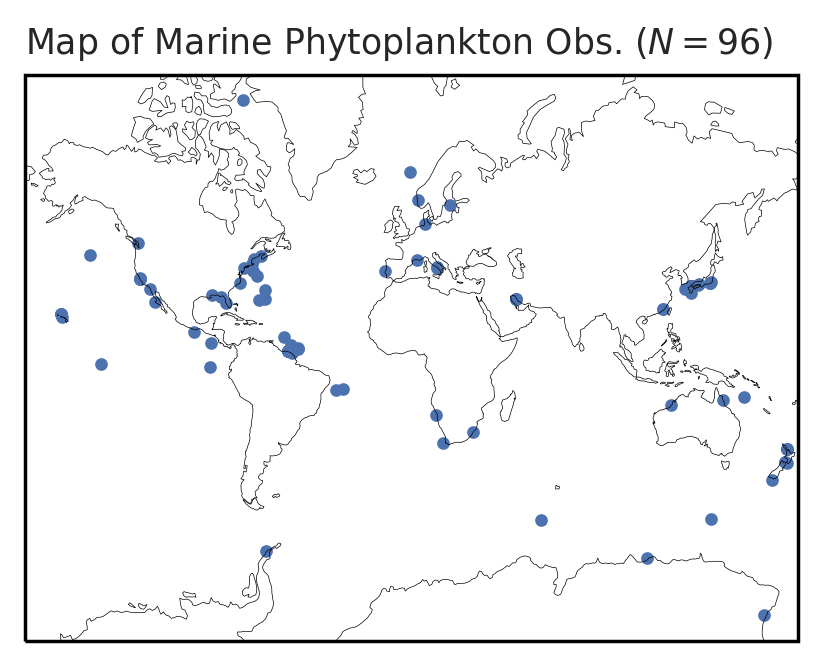

In [6]:
fig, ax =plt.subplots(1, 1,dpi=250, figsize=(6, 3), subplot_kw={'projection' : ccrs.Mercator()})
a = plankton.plot( ax=ax, transform=ccrs.PlateCarree(), markersize=7, vmin=0,  legend=True)
ax.add_feature(cf.COASTLINE, linewidth=0.2)
plt.title(r"Map of Marine Phytoplankton Obs." +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 10}, loc='left')

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


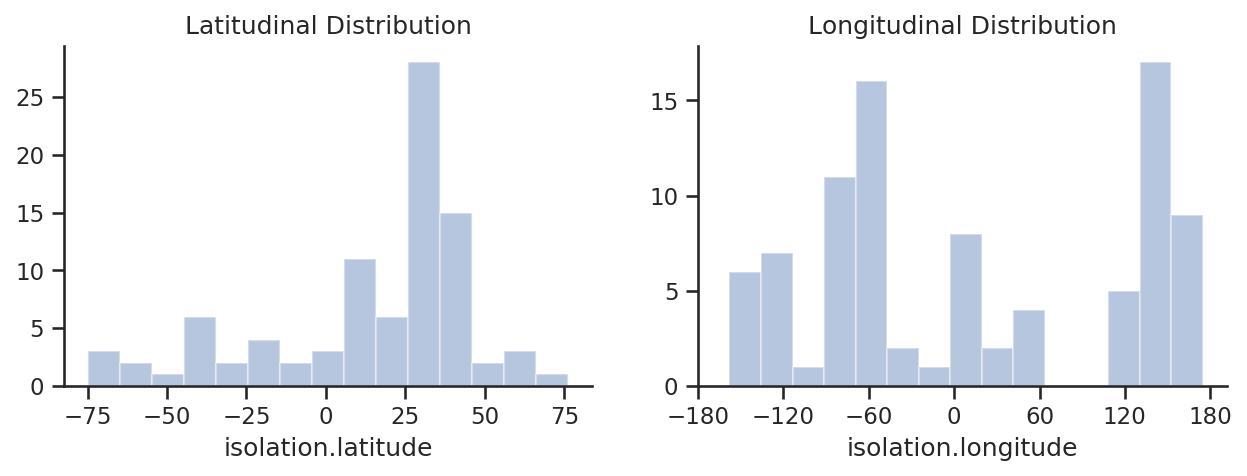

In [7]:
sns.set(style='ticks')
fig, axes = plt.subplots(1, 2, figsize=(10,3), dpi=150)
sns.distplot(plankton['isolation.latitude'], kde=False, ax=axes[0], bins=15)

axes[0].set_title("Latitudinal Distribution")

sns.distplot(plankton['isolation.longitude'], kde=False, ax=axes[1], bins=15)
axes[1].set_xticks(np.arange(-180, 181,60))
axes[1].set_title("Longitudinal Distribution")
sns.despine()



# $T_\mathrm{opt}$

In [7]:
t_opt_colname = 'mu.g.opt.list' #29) mu.g.opt.list = estimated optimum temperature for growth 

## Maps of $T_{\mathrm{opt}}$

Text(0.0, 1, 'Map of $T_{\\mathrm{opt}}$ ($N = 96$)')

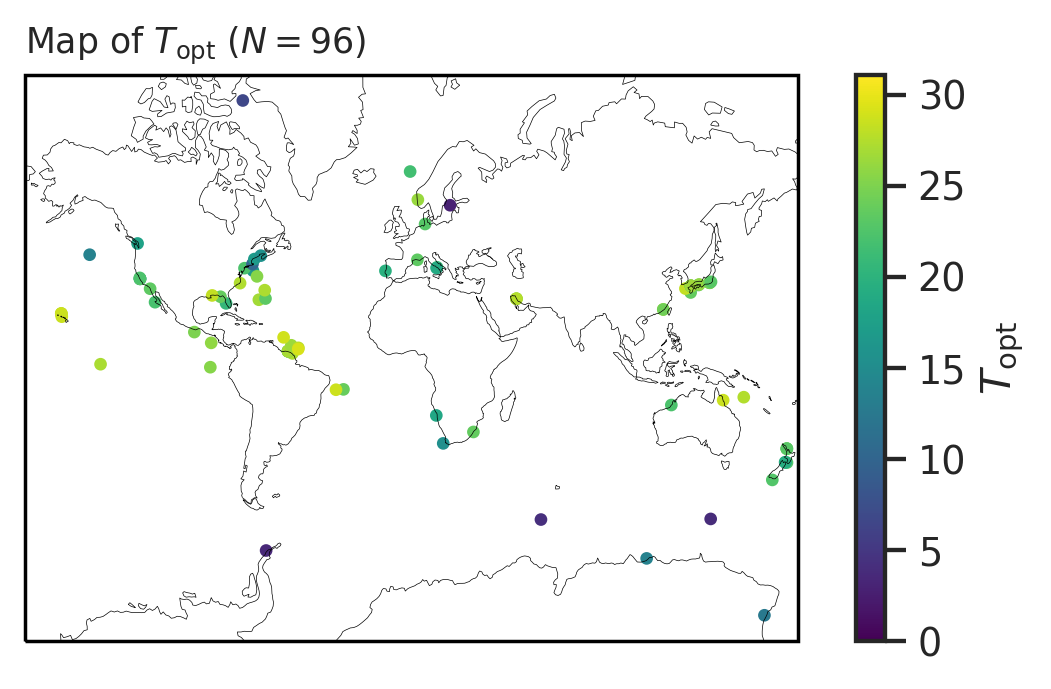

In [9]:
fig, ax =plt.subplots(1, 1,dpi=250, figsize=(6, 3), subplot_kw={'projection' : ccrs.Mercator()})
a = plankton.plot(column=t_opt_colname, ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', markersize=7, vmin=0,  legend=True, legend_kwds={'label': r"$T_{\mathrm{opt}}$"})
ax.add_feature(cf.COASTLINE, linewidth=0.2)
plt.title(r"Map of $T_{\mathrm{opt}}$" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 10}, loc='left')

## $T_\mathrm{opt}$ as a function of Latitude

In [8]:
t_opt_colname= 'mu.g.opt.list' # 29) mu.g.opt.list = estimated optimum temperature for growth 

In [9]:
plankton['abslat'] = plankton['isolation.latitude'].abs()

We'll drop any rows with `NaN` values in any of the latitude, longitude or $T_{\mathrm{opt}}$ columns. 

In [12]:
plankton = plankton.dropna(axis=0, subset=['abslat', 'isolation.latitude', 'isolation.longitude', t_opt_colname])

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.0, 1, '$T_{\\mathrm{opt}}$ by Latitude ($N = 89$)')

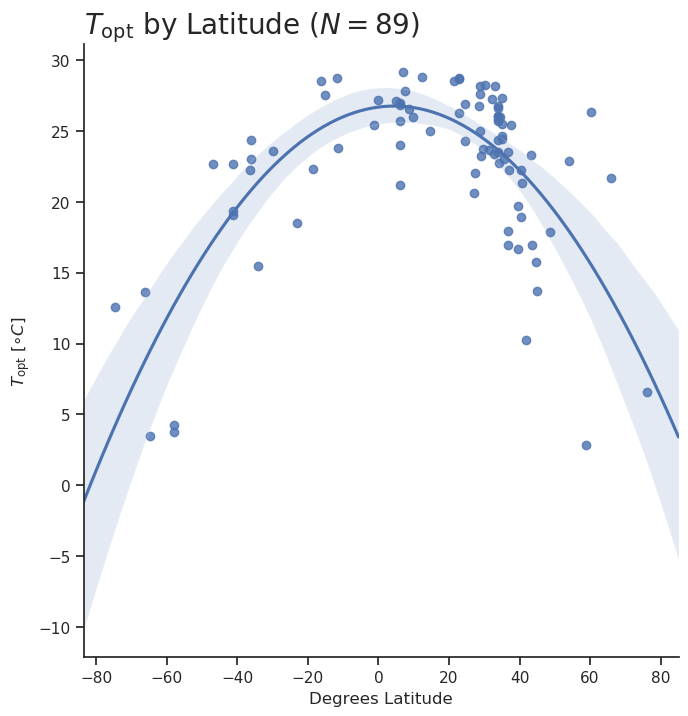

In [13]:
fg = sns.lmplot(x='isolation.latitude', y=t_opt_colname, data=plankton, size=7, order=2)

fg.fig.set_dpi(100)
plt.ylabel(r"$T_{\mathrm{opt}}$ [$\circ C$]")
plt.xlabel(r"Degrees Latitude")
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"$T_{\mathrm{opt}}$ by Latitude" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')


Text(0.0, 1, '$T_{\\mathrm{opt}}$ by Latitude ($N = 89$)')

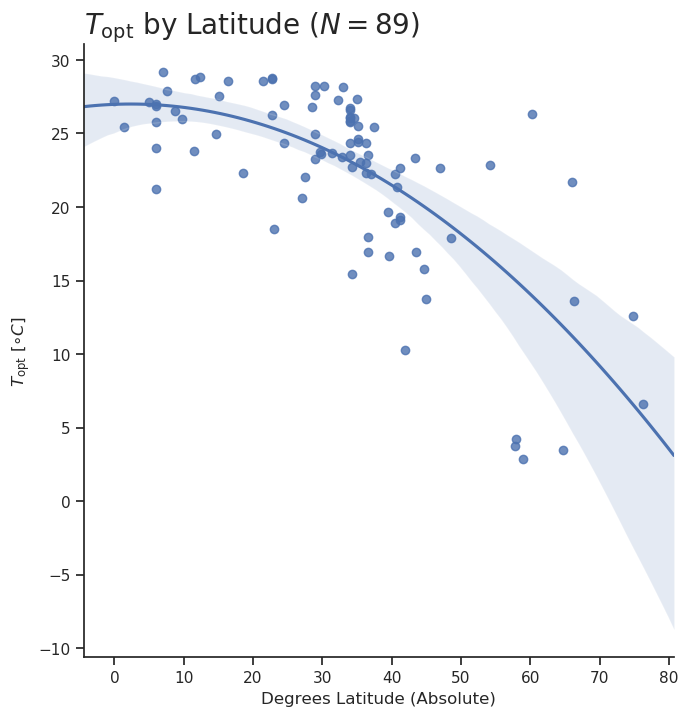

In [15]:
fg = sns.lmplot(x='abslat', y=t_opt_colname, data=plankton, size=7, )
fg.fig.set_dpi(100)
plt.ylabel(r"$T_{\mathrm{opt}}$ [$\circ C$]")
plt.xlabel(r"Degrees Latitude (Absolute)")
plt.title(r"$T_{\mathrm{opt}}$ by Latitude" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')

Text(0.0, 1, '$T_{\\mathrm{opt}}$ by Latitude ($N = 89$)')

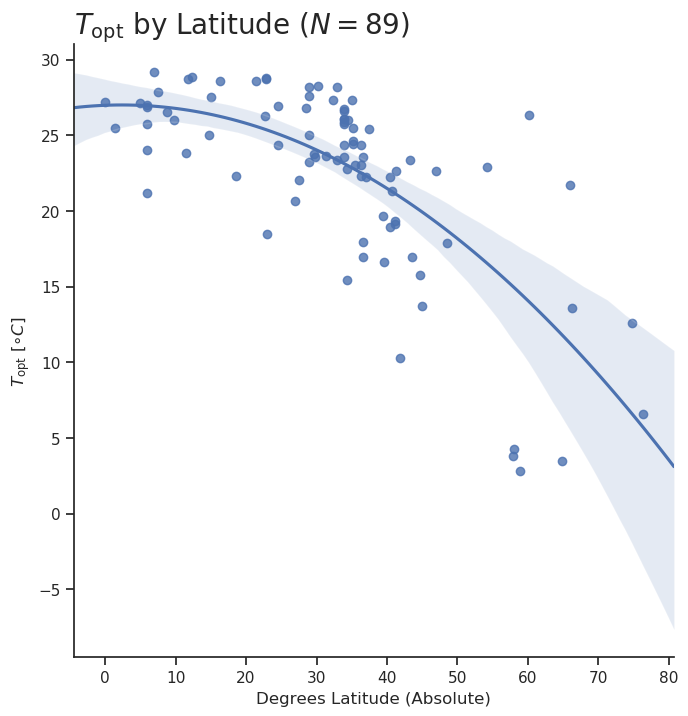

In [16]:
fg = sns.lmplot(x='abslat', y=t_opt_colname, data=plankton, size=7, order=2)
fg.fig.set_dpi(100)
plt.ylabel(r"$T_{\mathrm{opt}}$ [$\circ C$]")
plt.xlabel(r"Degrees Latitude (Absolute)")
plt.title(r"$T_{\mathrm{opt}}$ by Latitude" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')

## Examine Statistics of $T_\mathrm{opt}$ Fits

We'll re-create the above fits manually below: 

### 1) Second-order fit  (regular latitude)

In [24]:
lat_column = 'isolation.latitude'

topt = plankton[t_opt_colname]

order2 = PolynomialFeatures(2).fit_transform(plankton[lat_column].to_numpy().reshape(-1,1))

results_lat = sm.OLS(topt, order2).fit()

results_lat.summary(title="Regular Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Regular Latitude (Second order fit) Results                  
==============================================================================
Dep. Variable:          mu.g.opt.list   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     52.85
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.07e-15
Time:                        17:44:51   Log-Likelihood:                -250.59
No. Observations:                  89   AIC:                             507.2
Df Residuals:                      86   BIC:                             514.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.7031      0.686     38.908      0.000      25.339      28.067
x1             0.0323      0.013      2.432      0.017       0.006       0.059
x2            -0.0036      0.000     -9.821      0.000      -0.004      -0.003
==============================================================================
Omnibus:                       10.231   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.412
Skew:                          -0.627   Prob(JB):                      0.00333
Kurtosis:                       4.226   Cond. No.                     2.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, -5, 'statsmodels fit')

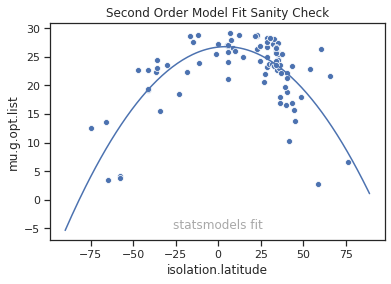

In [27]:
X = PolynomialFeatures(2).fit_transform(np.arange(-90, 90).reshape(-1,1))
topt_hat = results_lat.predict(X)
sns.scatterplot(x = 'isolation.latitude', y = t_opt_colname, data=plankton)
plt.plot(np.arange(-90, 90), topt_hat)
plt.title("Second Order Model Fit Sanity Check")
plt.annotate("statsmodels fit", (0, -5), alpha=0.4, horizontalalignment='center')

In [29]:
results_lat.save("latitude_polynomial_topt.model", remove_data=False)

### 2) Linear fit Statistics (absolute latitude)

In [21]:
lat_column = 'abslat'

topt = plankton[t_opt_colname]
lat = sm.add_constant(plankton[lat_column])

results_absolute = sm.OLS(topt, lat).fit()
results_absolute.summary(title="Absolute Latitude 1st Order model Results")

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Absolute Latitude 1st Order model Results                   
==============================================================================
Dep. Variable:          mu.g.opt.list   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     73.36
Date:                Fri, 10 Apr 2020   Prob (F-statistic):           3.48e-13
Time:                        17:15:07   Log-Likelihood:                -259.05
No. Observations:                  89   AIC:                             522.1
Df Residuals:                      87   BIC:                             527.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.5298      1.053     29.004      0.000      28.438      32.622
abslat        -0.2494      0.029     -8.565      0.000      -0.307      -0.192
==============================================================================
Omnibus:                       11.404   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.749
Skew:                          -0.789   Prob(JB):                      0.00281
Kurtosis:                       3.824   Cond. No.                         79.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(1, 5, 'statsmodels fit')

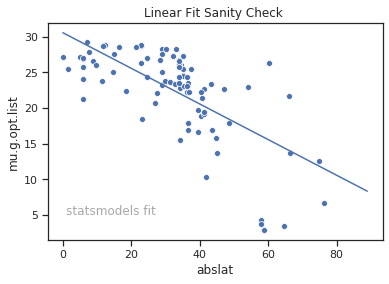

In [22]:
X = sm.add_constant(np.arange(0, 90))
topt_hat = results_absolute.predict(X)
sns.scatterplot(x = 'abslat', y = t_opt_colname, data=plankton)
plt.plot(np.arange(0, 90), topt_hat)
plt.title("Linear Fit Sanity Check ")
plt.annotate("statsmodels fit", (1, 5), alpha=0.4, horizontalalignment='left')

## 3) Second-order fit (absolute latitude)

In [19]:
lat_column = 'abslat'

topt = plankton[t_opt_colname]

order2 = PolynomialFeatures(2).fit_transform(plankton[lat_column].to_numpy().reshape(-1,1))

results_absolute_poly = sm.OLS(topt, order2).fit()

results_absolute_poly.summary(title="Absolute Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Absolute Latitude (Second order fit) Results                 
==============================================================================
Dep. Variable:          mu.g.opt.list   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     46.73
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.83e-14
Time:                        17:39:10   Log-Likelihood:                -253.52
No. Observations:                  89   AIC:                             513.0
Df Residuals:                      86   BIC:                             520.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.9813      1.448     18.627      0.000      24.102      29.861
x1             0.0184      0.084      0.219      0.827      -0.149       0.186
x2            -0.0039      0.001     -3.371      0.001      -0.006      -0.002
==============================================================================
Omnibus:                        9.424   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.280
Skew:                          -0.537   Prob(JB):                      0.00355
Kurtosis:                       4.374   Cond. No.                     5.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(1, 5, 'statsmodels fit')

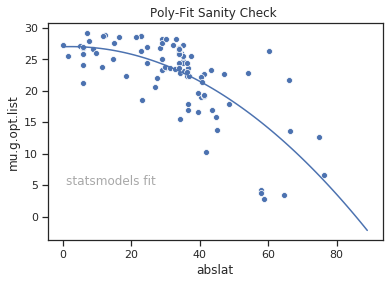

In [22]:
X = PolynomialFeatures(2).fit_transform(np.arange(0, 90).reshape(-1,1))
topt_hat = results_absolute_poly.predict(X)
sns.scatterplot(x = 'abslat', y = t_opt_colname, data=plankton)
plt.plot(np.arange(0, 90), topt_hat)
plt.title("Poly-Fit Sanity Check ")
plt.annotate("statsmodels fit", (1, 5), alpha=0.4, horizontalalignment='left')

In [23]:
results_absolute_poly.save("absolute_latitude_polynomial_topt.model", remove_data=True)

## $T_{\mathrm{opt}}$ by Latitude in Longitudinal Bins

In [23]:
plankton['lonbin'] = pd.cut(plankton['isolation.longitude'], 10)

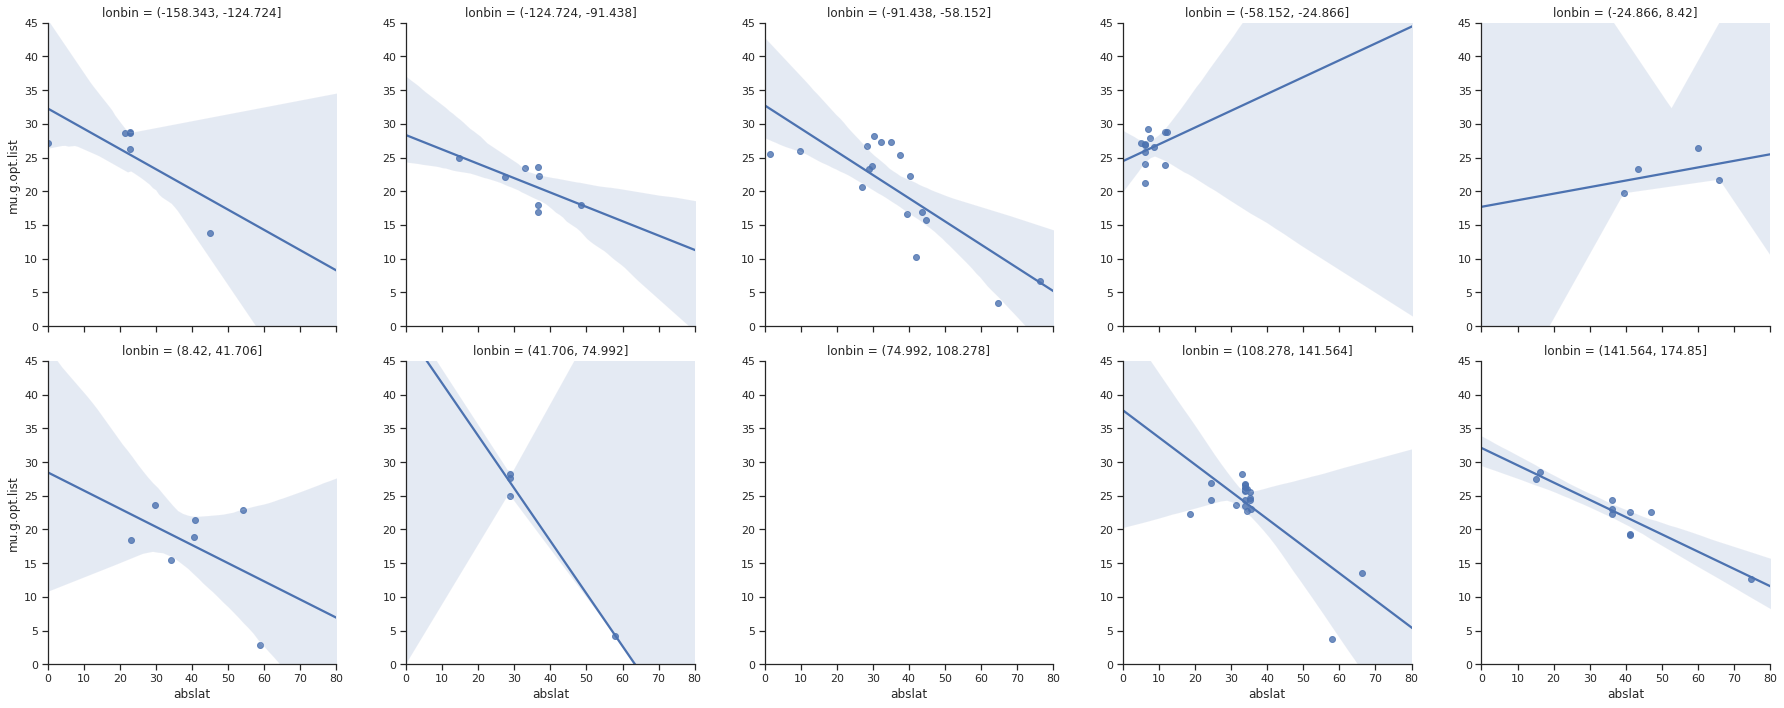

In [24]:
fg = sns.lmplot(x='abslat', y=t_opt_colname, col='lonbin', col_wrap=5, data=plankton, sharey=False, )
list(map(lambda x: x.set_xlim(0, 80) and x.set_ylim(0, 45), fg.axes.ravel()));

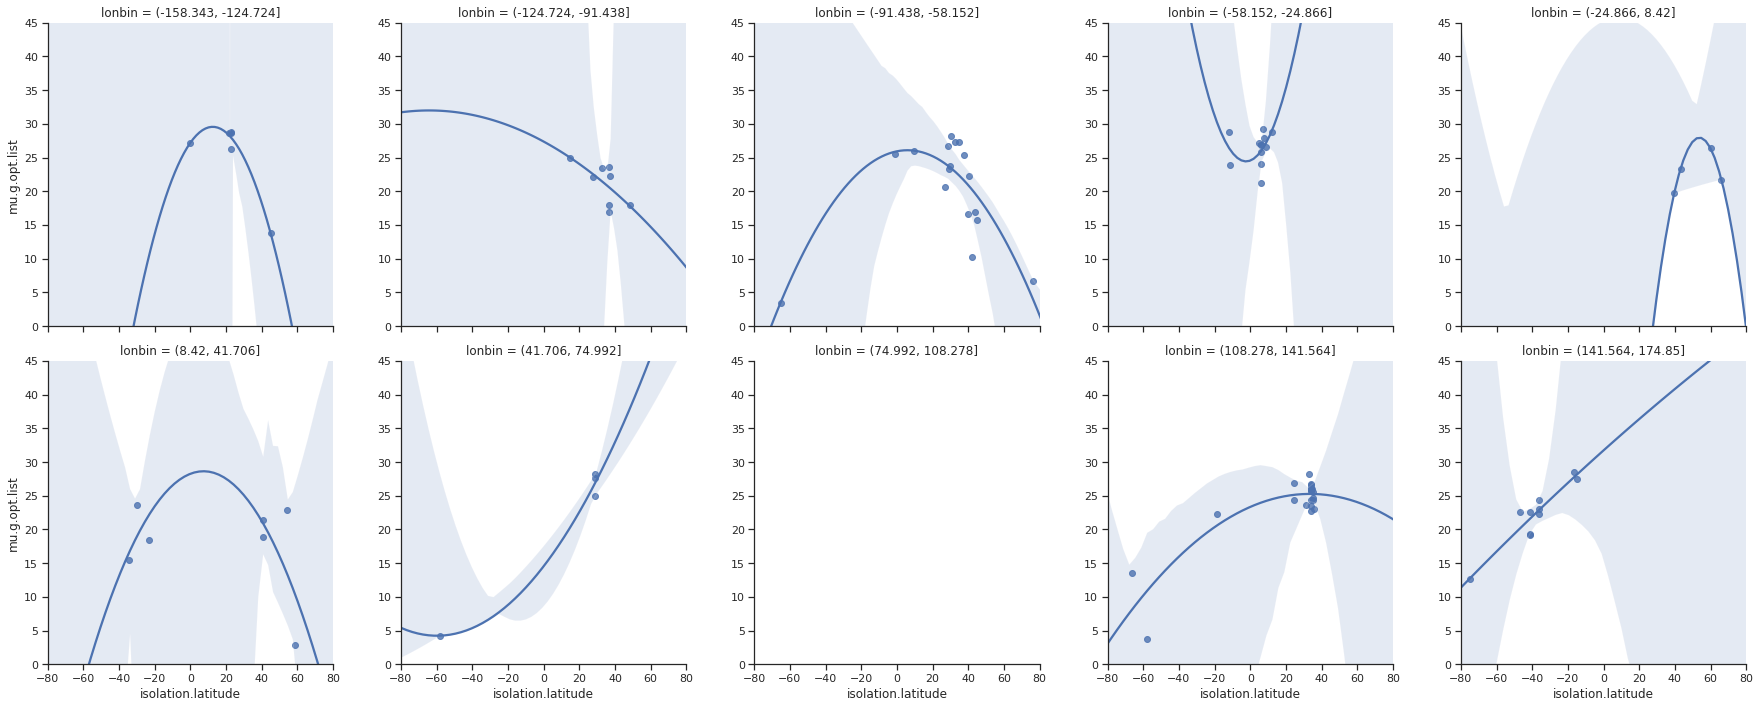

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fg = sns.lmplot(x='isolation.latitude', y=t_opt_colname, col='lonbin', col_wrap=5, data=plankton, sharey=False, order=2)
    list(map(lambda x: x.set_xlim(-80, 80) and x.set_ylim(0, 45), fg.axes.ravel()));

# Thermal Breadth ($T_\mathrm{max} - T_\mathrm{min}$)

In [26]:
niche_width_colname = 'mu.wlist' # 23) mu.wlist = estimated thermal niche width (parameter ‘ɷ’ in the thermal reaction norm model)

## Maps of Thermal Breadth

In [27]:
geoplankton = gpd.GeoDataFrame(plankton, geometry = [geometry.Point(_['isolation.longitude'], _['isolation.latitude']) for i,_ in plankton.iterrows()])

Text(0.0, 1, 'Map of Niche Breadth ($N = 89$)')

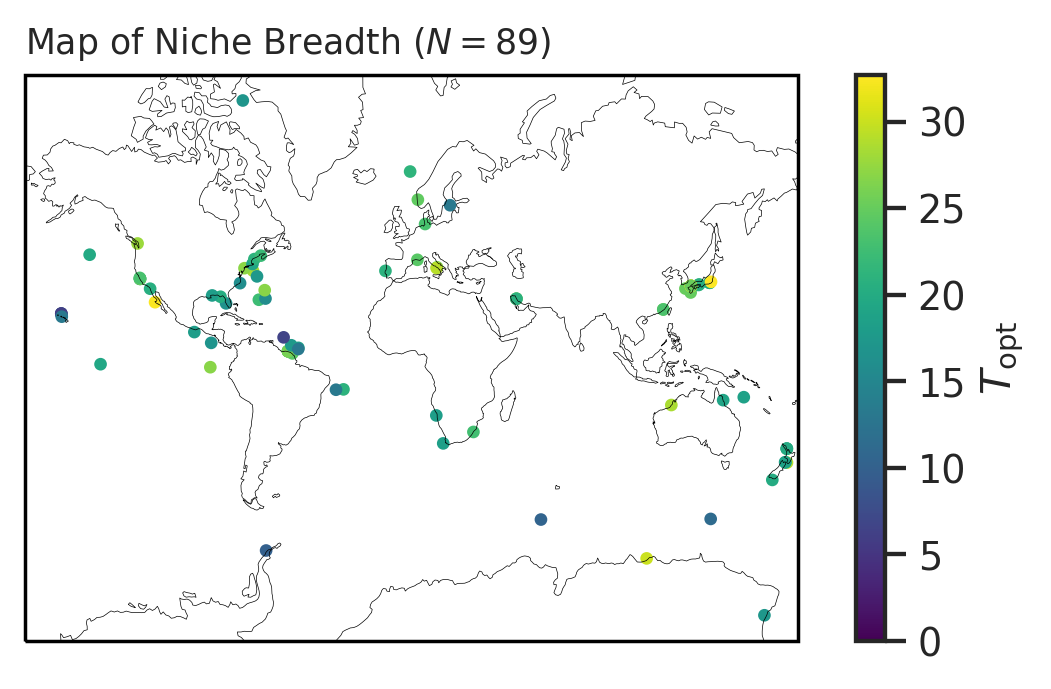

In [28]:
fig, ax =plt.subplots(1, 1,dpi=250, figsize=(6, 3), subplot_kw={'projection' : ccrs.Mercator()})
a = plankton.plot(column='mu.wlist', ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', markersize=7, vmin=0,  legend=True, legend_kwds={'label': r"$T_{\mathrm{opt}}$"})
ax.add_feature(cf.COASTLINE, linewidth=0.2)
plt.title(r"Map of Niche Breadth" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 10}, loc='left')

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.0, 1, 'Niche Breadth by Latitude ($N = 89$)')

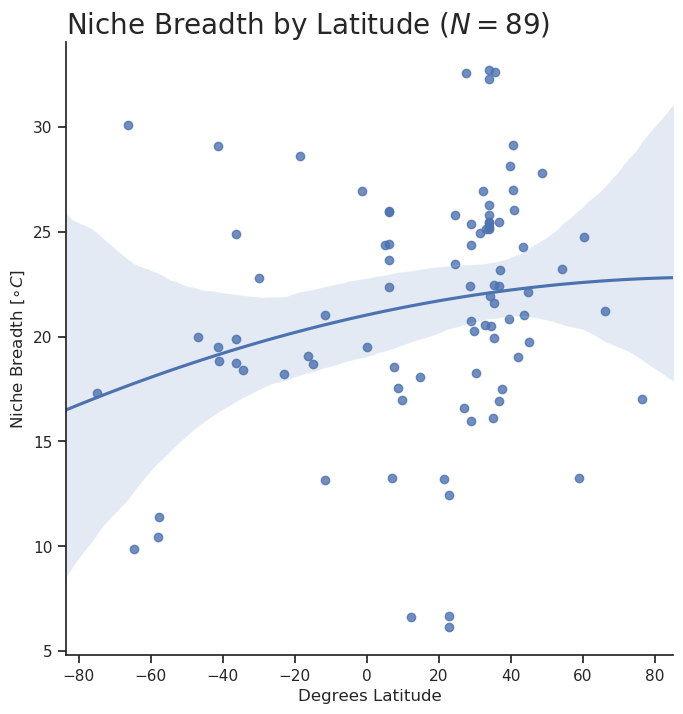

In [29]:
fg = sns.lmplot(x='isolation.latitude', y='mu.wlist', data=plankton, size=7, order=2)

fg.fig.set_dpi(100)
plt.ylabel(r"Niche Breadth [$\circ C$]")
plt.xlabel(r"Degrees Latitude")
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"Niche Breadth by Latitude" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')


Text(0.0, 1, 'Niche Breadth by Absolute Latitude ($N = 89$)')

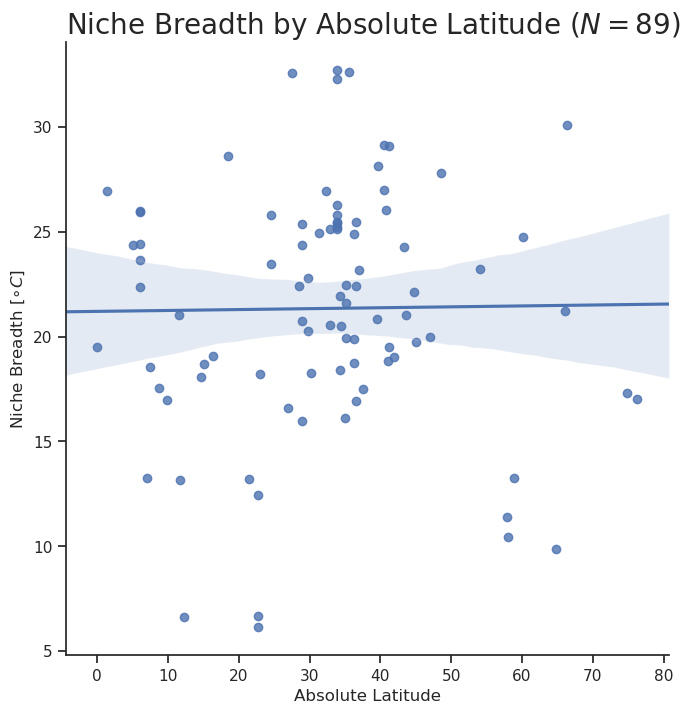

In [30]:
fg = sns.lmplot(x='abslat', y='mu.wlist', data=plankton, size=7, order=1)

fg.fig.set_dpi(100)
plt.ylabel(r"Niche Breadth [$\circ C$]")
plt.xlabel(r"Absolute Latitude")
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"Niche Breadth by Absolute Latitude" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')


# Skew 

In [31]:
abskew_colname = 'abs.curveskew' # 38) abs.curveskew = Estimated absolute skewness of the thermal reaction norm
relskew_colname = 'rel.curveskew'# 39) rel.curveskew = Estimated relative skewness of the thermal reaction norm

Text(0.0, 1, 'Map of Absolute Skew ($N = 89$)')

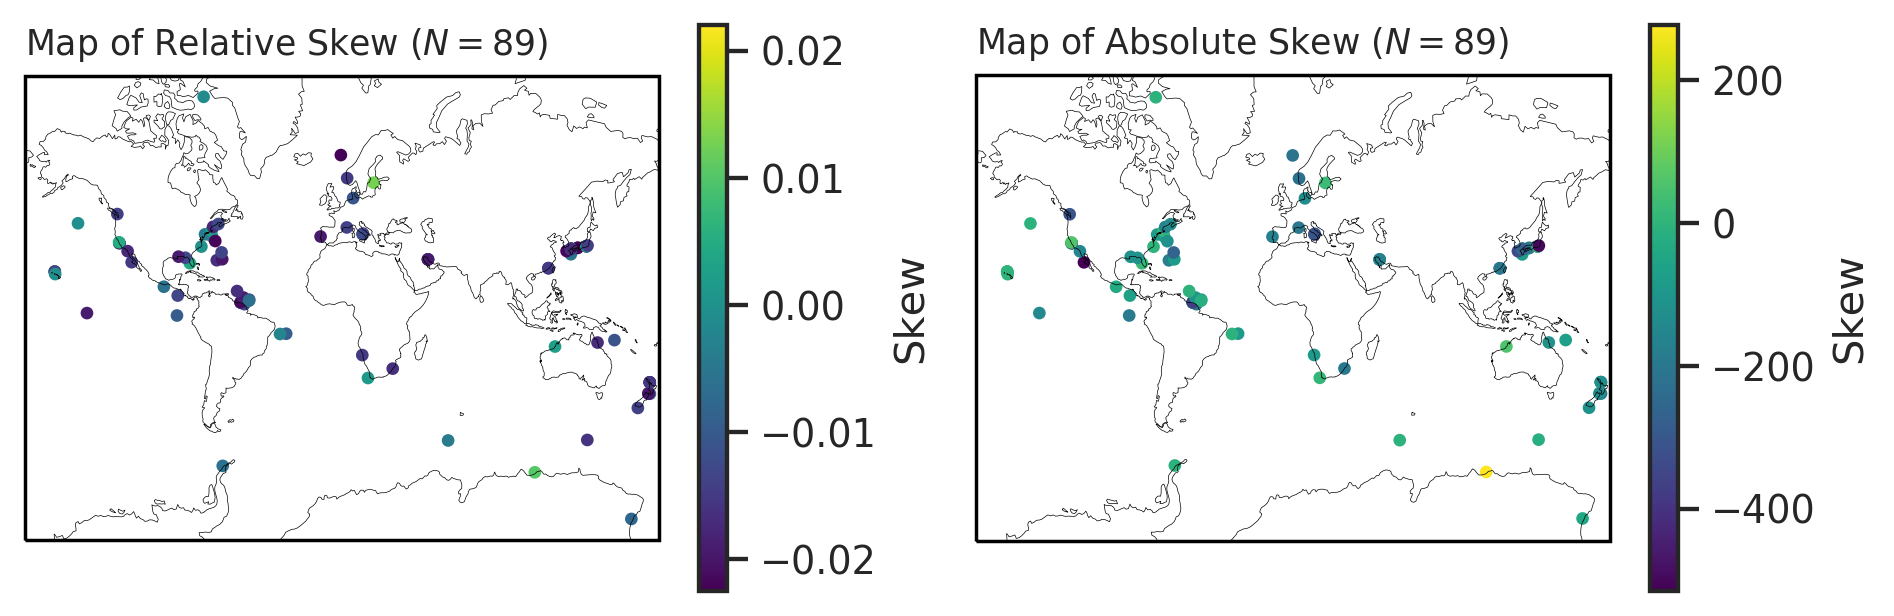

In [32]:
fig, axes =plt.subplots(1, 2,dpi=250, figsize=(9, 3), subplot_kw={'projection' : ccrs.Mercator()})
a = plankton.plot(column=relskew_colname, ax=axes[0], transform=ccrs.PlateCarree(), cmap='viridis', markersize=7,  legend=True, legend_kwds={'label': r"Skew"})
axes[0].add_feature(cf.COASTLINE, linewidth=0.2)
axes[0].set_title(r"Map of Relative Skew" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 10}, loc='left')

a = plankton.plot(column=abskew_colname, ax=axes[1], transform=ccrs.PlateCarree(), cmap='viridis', markersize=7,  legend=True, legend_kwds={'label': r"Skew"})
axes[1].add_feature(cf.COASTLINE, linewidth=0.2)
axes[1].set_title(r"Map of Absolute Skew" +" ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 10}, loc='left')

## Skew by Latitude

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.0, 1, 'Relative Skew by Latitude')

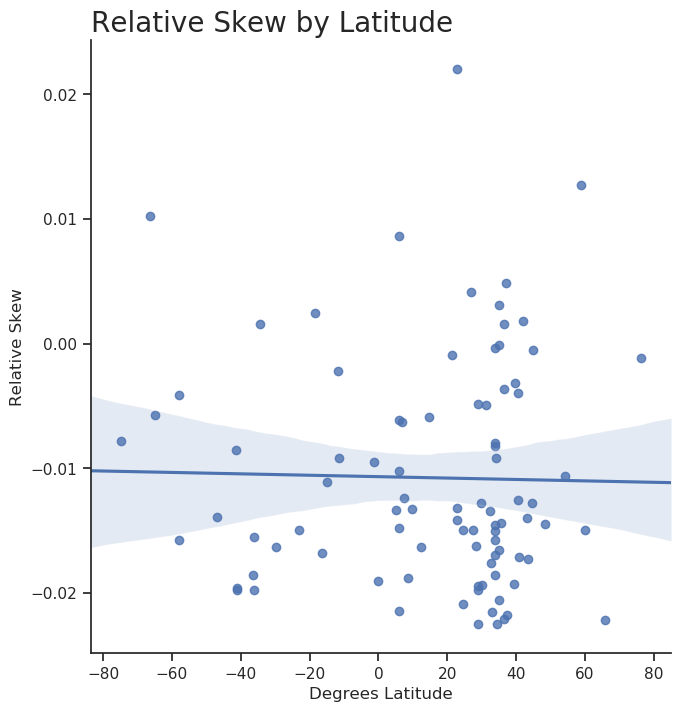

In [33]:

fg = sns.lmplot(x='isolation.latitude', y=relskew_colname, data=plankton, size=7, order=1)

fg.fig.set_dpi(100)
plt.ylabel(r"Relative Skew")
plt.xlabel(r"Degrees Latitude")
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"Relative Skew by Latitude".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')

Text(0.0, 1, 'Relative Skew by Absolute Latitude')

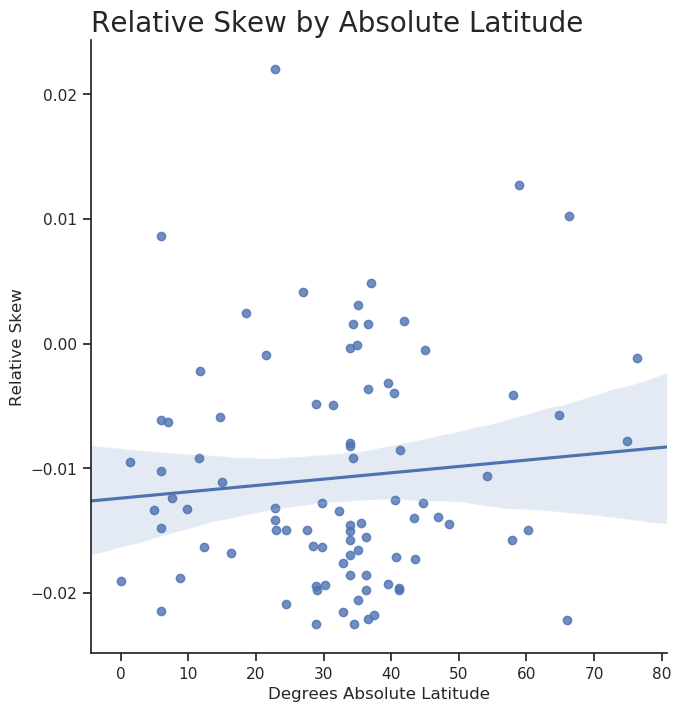

In [34]:
fg = sns.lmplot(x='abslat', y=relskew_colname, data=plankton, size=7, order=1)

fg.fig.set_dpi(100)
plt.ylabel(r"Relative Skew")
plt.xlabel(r"Degrees Absolute Latitude")
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"Relative Skew by Absolute Latitude".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')

## $T_\mathrm{min}$ and $T_\mathrm{max}$ by longitude

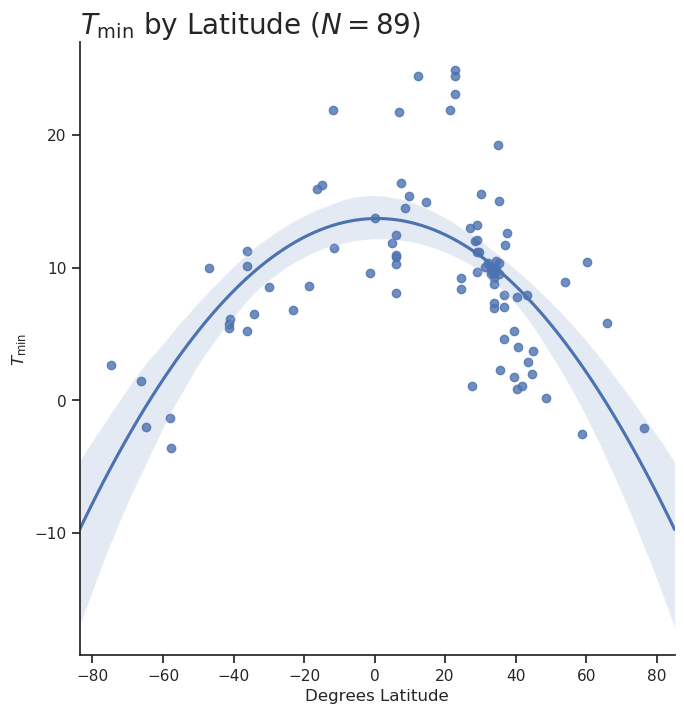

In [51]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fg= sns.lmplot(x = 'isolation.latitude', y = 'tmin', data=plankton, height=7, order=2)
    fg.fig.set_dpi(100)
    plt.ylabel(r"$T_\mathrm{min}$")
    plt.xlabel(r"Degrees Latitude")
#     plt.ylim([plankton['tmin'].min(), plankton['tmin'].max()])
    # plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
    plt.title(r"$T_\mathrm{min}$ by Latitude" + " ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')

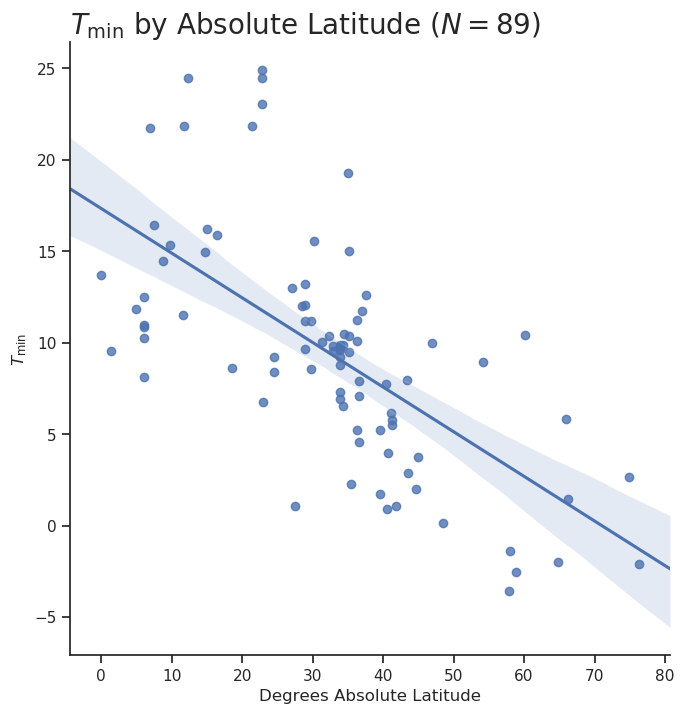

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fg= sns.lmplot(x = 'abslat', y = 'tmin', data=plankton, height=7, order=2)
    fg.fig.set_dpi(100)
    plt.ylabel(r"$T_\mathrm{min}$")
    plt.xlabel(r"Degrees Absolute Latitude")
#     plt.ylim([plankton['tmin'].min(), plankton['tmin'].max()])
    # plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
    plt.title(r"$T_\mathrm{min}$ by Absolute Latitude" + " ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')

Text(0.0, 1, '$T_\\mathrm{max}$ by Latitude ($N = 89$)')

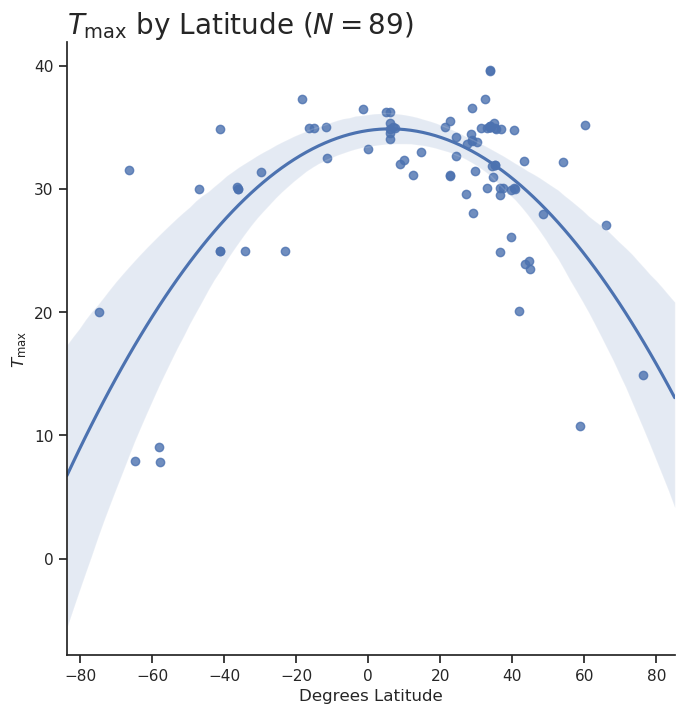

In [43]:
fg= sns.lmplot(x = 'isolation.latitude', y = 'tmax', data=plankton, height=7, order=2)
fg.fig.set_dpi(100)
plt.ylabel(r"$T_\mathrm{max}$")
plt.xlabel(r"Degrees Latitude")
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"$T_\mathrm{max}$ by Latitude" + " ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')

Text(0.0, 1, '$T_\\mathrm{max}$ by Absolute Latitude ($N = 96$)')

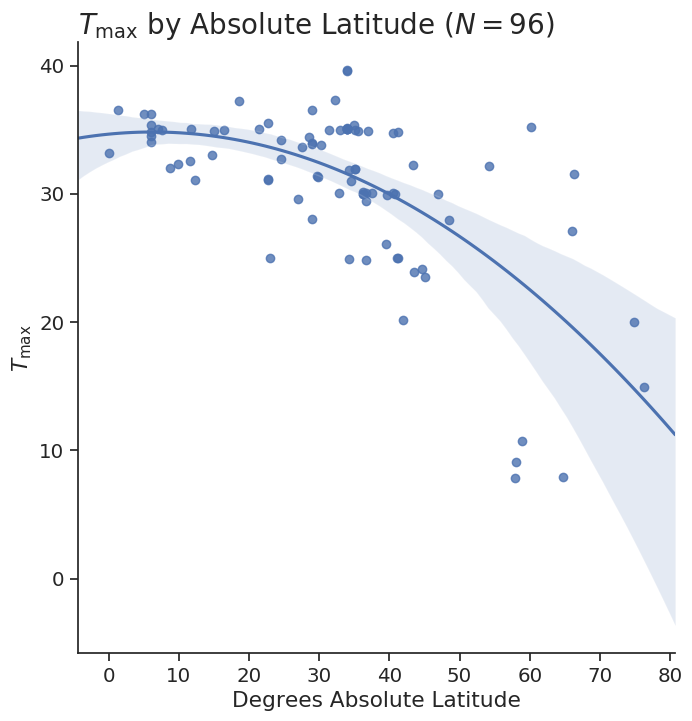

In [11]:
fg= sns.lmplot(x = 'abslat', y = 'tmax', data=plankton, height=7, order=2)
fg.fig.set_dpi(100)
plt.ylabel(r"$T_\mathrm{max}$")
plt.xlabel(r"Degrees Absolute Latitude")
#     plt.ylim([plankton['tmin'].min(), plankton['tmin'].max()])
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"$T_\mathrm{max}$ by Absolute Latitude" + " ($N = {}$)".format(len(plankton)), fontdict={'fontsize': 20}, loc='left')

# Assess longitudinal fit with Relaxed Data Filter 

In [54]:
plankton_relaxed = plankton_o[
    plankton_o.habitat == 'marine'
].dropna(axis=0, subset=['isolation.latitude', 'isolation.longitude', 'tmin', 'tmax', t_opt_colname])
plankton_relaxed['abslat'] = abs(plankton_relaxed['isolation.latitude'])

In [ ]:
plankton_

In [19]:
len(plankton_relaxed)

183

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.0, 1, '$T_{\\mathrm{opt}}$ by Latitude ($N = 183$)')

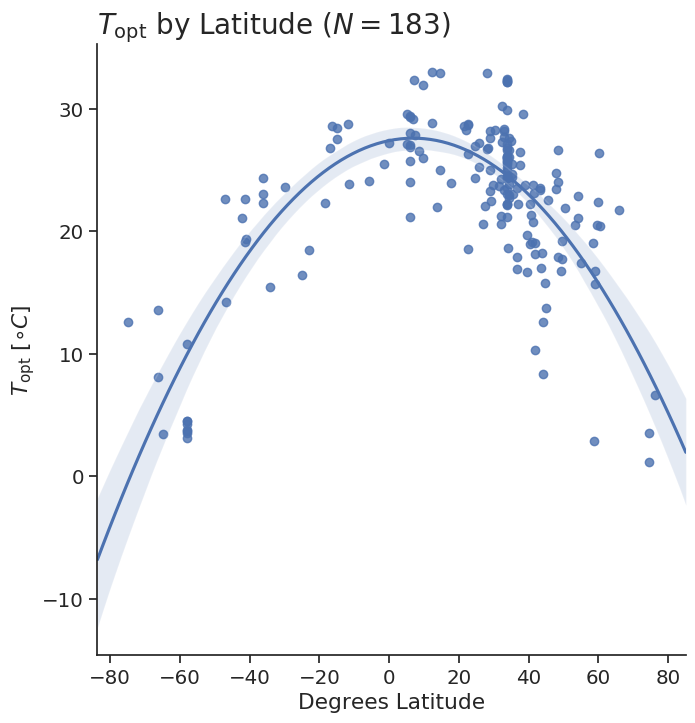

In [20]:

fg = sns.lmplot(x='isolation.latitude', y=t_opt_colname, data=plankton_relaxed, size=7, order=2)

fg.fig.set_dpi(100)
plt.ylabel(r"$T_{\mathrm{opt}}$ [$\circ C$]")
plt.xlabel(r"Degrees Latitude")
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"$T_{\mathrm{opt}}$ by Latitude" +" ($N = {}$)".format(len(plankton_relaxed)), fontdict={'fontsize': 20}, loc='left')


In [58]:
lat_column = 'isolation.latitude'

topt = plankton_relaxed[t_opt_colname]

order2 = PolynomialFeatures(2).fit_transform(plankton_relaxed[lat_column].to_numpy().reshape(-1,1))

results_lat_relaxed = sm.OLS(topt, order2).fit()

results_lat_relaxed.summary(title="Regular Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Regular Latitude (Second order fit) Results                  
==============================================================================
Dep. Variable:          mu.g.opt.list   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     143.1
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           6.41e-38
Time:                        16:43:48   Log-Likelihood:                -524.29
No. Observations:                 183   AIC:                             1055.
Df Residuals:                     180   BIC:                             1064.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3987      0.537     51.041      0.000      26.340      28.458
x1             0.0580      0.010      5.981      0.000       0.039       0.077
x2            -0.0042      0.000    -15.965      0.000      -0.005      -0.004
==============================================================================
Omnibus:                        5.208   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.840
Skew:                          -0.222   Prob(JB):                       0.0539
Kurtosis:                       3.754   Cond. No.                     3.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
results_lat_relaxed.save("latitude_polynomial_topt_relaxed.model")

Text(0.0, 1, '$T_{\\mathrm{opt}}$ by Latitude ($N = 183$)')

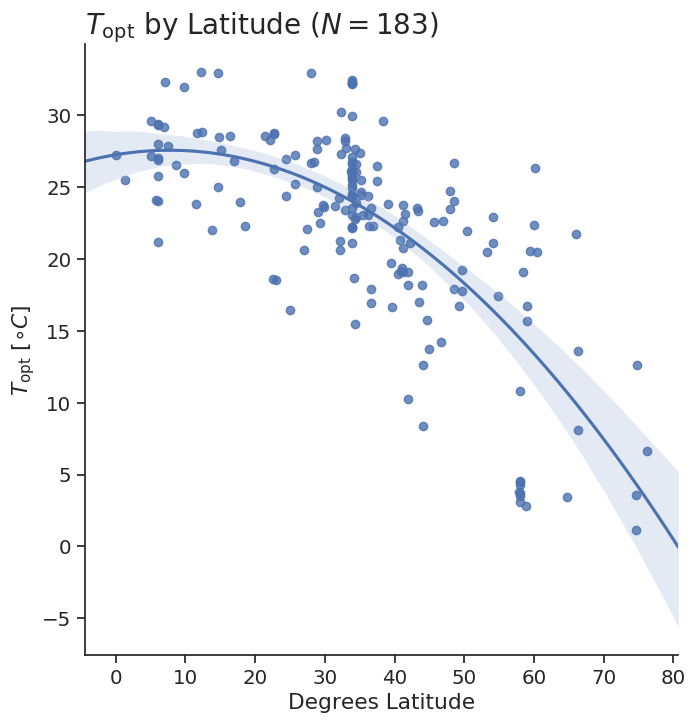

In [55]:

fg = sns.lmplot(x='abslat', y=t_opt_colname, data=plankton_relaxed, size=7, order=2)

fg.fig.set_dpi(100)
plt.ylabel(r"$T_{\mathrm{opt}}$ [$\circ C$]")
plt.xlabel(r"Degrees Latitude")
# plt.title(r"$T_{\mathrm{opt}}$ by Latitude", fontdict={'fontsize': 20})
plt.title(r"$T_{\mathrm{opt}}$ by Latitude" +" ($N = {}$)".format(len(plankton_relaxed)), fontdict={'fontsize': 20}, loc='left')


In [56]:
lat_column = 'abslat'

topt = plankton_relaxed[t_opt_colname]

order2 = PolynomialFeatures(2).fit_transform(plankton_relaxed[lat_column].to_numpy().reshape(-1,1))

results_abslat_relaxed = sm.OLS(topt, order2).fit()

results_abslat_relaxed.summary(title="Regular Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Regular Latitude (Second order fit) Results                  
==============================================================================
Dep. Variable:          mu.g.opt.list   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     105.8
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           4.12e-31
Time:                        16:16:11   Log-Likelihood:                -540.23
No. Observations:                 183   AIC:                             1086.
Df Residuals:                     180   BIC:                             1096.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.2447      1.260     21.623      0.000      24.758      29.731
x1             0.0804      0.071      1.132      0.259      -0.060       0.220
x2            -0.0052      0.001     -5.441      0.000      -0.007      -0.003
==============================================================================
Omnibus:                        5.726   Durbin-Watson:                   1.197
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.450
Skew:                          -0.345   Prob(JB):                       0.0655
Kurtosis:                       3.490   Cond. No.                     6.99e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Better fit with all marine species + regular latitude**